In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
from astropy.constants import G, M_earth, R_earth
from astropy import units as u
import numpy as np
import math

In [3]:
# Need semi major axis, eccentricity, argument of periapsis, long of ascending node, inclination, mean anomaly



max_alt = 418000
min_alt = 417000


planet_radius = 6371000
planet_mass = 5.972e24
universal_grav_constant = 6.67e-11
#print(universal_grav_constant)

e = eccentricity = 0.0000271
w = argument_of_periapsis = 59.6597
omega = ascending_node_long = 206.5281
i = inclination = 51.6427
Ma = mean_anomaly = 279.2646
t = considered_epoch = 0


Apoapsis = max_alt + planet_radius
Periapsis = min_alt + planet_radius 
a = semi_major_axis = (Apoapsis + Periapsis) / 2

mu = stand_grav_param = planet_mass * universal_grav_constant
print(mu)

398332400000000.0


In [4]:
# Root finder for eccentric anomaly

def sign(x):
    if x > 0:
        return 1
    else:
        return -1

def Ecc_Anom_Function(E, M, e, in_rads):
    if in_rads == False:
        E = E * np.pi / 180
        M = M * np.pi / 180 
        return np.degrees((E - (e * np.sin(E))) - M)
    else:
        return (E - (e * np.sin(E))) - M

def Ecc_Anom_Root_Finder(E_min, E_max, tolerance, mean_anomaly, e, in_rads):
    
    iterations = 0
    E_left = E_min
    E_right = E_max
    
    while abs(E_left - E_right) > tolerance:
        iterations += 1
        E_mid = (E_left + E_right) / 2
        if sign(Ecc_Anom_Function(E_mid, mean_anomaly, e, in_rads)) == sign(Ecc_Anom_Function(E_left, mean_anomaly, e, in_rads)):
            E_left = E_mid
        else:
            E_right = E_mid
    print(iterations)
    return((E_left + E_right) / 2, Ecc_Anom_Function((E_left + E_right) / 2, mean_anomaly, e, in_rads))

19
19
19
19
19


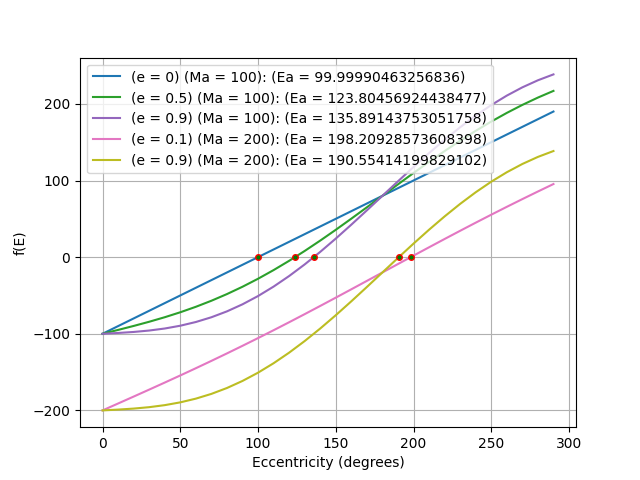

In [5]:
# A root finder visualization
quick_func = np.vectorize(Ecc_Anom_Function)


mean_anomaly_to_check = np.array([100, 100, 100, 200, 200])

#print(mean_anomaly_to_check)
ecc_to_check = [0, 0.5, 0.9, 0.1, 0.9]


axes = plt.axes()
#axes.grid(False)
axes.grid(True)
possible_Ecc = np.arange(0,300,10)

for i in range(len(ecc_to_check)):
    x, y = Ecc_Anom_Root_Finder(0, 500, 0.001, mean_anomaly_to_check[i], ecc_to_check[i], False)
    output_func = quick_func(possible_Ecc, mean_anomaly_to_check[i], ecc_to_check[i], False)
    
    axes.plot(possible_Ecc, output_func, label = f"(e = {ecc_to_check[i]}) (Ma = {mean_anomaly_to_check[i]}): (Ea = {x})")
    axes.plot(x, y, marker="o", markersize=4, markeredgecolor="red", markerfacecolor="green")
axes.set_xlabel("Eccentricity (degrees)")
axes.set_ylabel("f(E)")
axes.legend()
plt.show()

In [6]:
# Compute Mean Anomaly through epochs if needed (Ma)
Ma = np.radians(Ma)
#Ma = Ma + t * math.sqrt(mu / (a ** 3))

# Compute Eccentric Anomaly from root finder (Ea)
Ea, prox = Ecc_Anom_Root_Finder(0, 500, 0.00001, Ma, e, True)

#Ea = np.radians(Ea)

# Compute distance from satellite to the centre of the body (radius, Rc)

Rc = a * (1 - e * math.cos(Ea))

# Compute True Anomaly (v)

v = 2 * np.arctan2(math.sqrt(1 + e) * math.sin((Ea) / 2), math.sqrt(1 - e) * math.cos((Ea) / 2))
print(Ea, Ma, v, Rc)

26
4.874061793088913 4.8740867542649555 4.874035046431029 6788470.386719696


In [7]:
i = np.radians(i)
w = np.radians(w)
omega = np.radians(omega)

# Orbital Reference Frame
O = Rc * np.array([math.cos(v), math.sin(v), 0])
dO = (math.sqrt(mu * a) / Rc) * np.array([(-1 * math.sin(Ea)), (math.sqrt(1 - (e ** 2)) * math.cos(Ea)), 0])
print(O)
print(dO)

[ 1092557.00228619 -6699973.83488366        0.        ]
[7560.26614554 1233.05146612    0.        ]


In [8]:
# Transformation sequence to body-centric coordinates
# Position Section
Rx = O[0] * (math.cos(w) * math.cos(omega) - math.sin(w) * math.cos(i) * math.sin(omega)) - O[1] * (math.sin(w) * math.cos(omega) * math.cos(i) * math.sin(omega))
Ry = O[0] * (math.cos(w) * math.sin(omega) + math.sin(w) * math.cos(i) * math.cos(omega)) + O[1] * (math.cos(w) * math.cos(i) * math.cos(omega) - math.sin(w) * math.sin(omega))
Rz = O[0] * (math.sin(w) * math.sin(i)) + O[1] * (math.cos(w) * math.sin(i))
R = Rx, Ry, Rz

# Velocity Section
dRx = dO[0] * (math.cos(w) * math.cos(omega) - math.sin(w) * math.cos(i) * math.sin(omega)) - dO[1] * (math.sin(w) * math.cos(omega) * math.cos(i) * math.sin(omega))
dRy = dO[0] * (math.cos(w) * math.sin(omega) + math.sin(w) * math.cos(i) * math.cos(omega)) + dO[1] * (math.cos(w) * math.cos(i) * math.cos(omega) - math.sin(w) * math.sin(omega))
dRz =  dO[0] * (math.sin(w) * math.sin(i)) + dO[1] * (math.cos(w) * math.sin(i))
dR = dRx, dRy, dRz
print(R, dR)

(2231405.2380420384, -650003.7969818856, -170308.26298131832) (-933.9747649711642, -7609.9406833814455, 498.5964515836121)


In [9]:
print(math.sqrt((dRx ** 2 + dRy ** 2 + dRz ** 2)))

7683.235287801537
